## Solution

#### 1. Build the teleportation circuit

<img src="Image/teleportation1.jpeg" width=600 />


In [1]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from math import sqrt


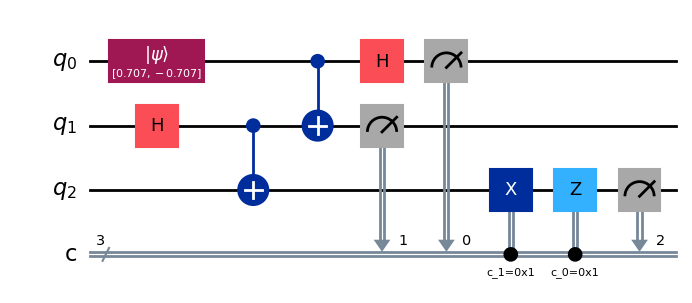

In [73]:

phi = Statevector([1/sqrt(2), -1/sqrt(2)])

teleport_circ = QuantumCircuit(3, 3)
teleport_circ.initialize(phi, 0)

teleport_circ.h(1)
teleport_circ.cx(1, 2)
teleport_circ.cx(0, 1)
teleport_circ.h(0)
teleport_circ.measure(0,0)
teleport_circ.measure(1,1)
teleport_circ.x(2).c_if(1,1)
teleport_circ.z(2).c_if(0,1)
teleport_circ.measure(2,2)
teleport_circ.draw('mpl')


To better visualize the results, we can use `plot_histogram` method from `qiskit.visualization`

In [3]:
from qiskit.visualization import plot_histogram

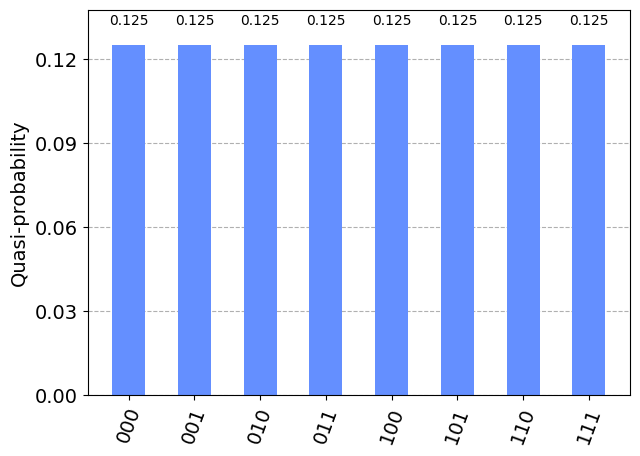

In [86]:

sampler = Sampler()
# sampler.set_options(shots=2048)
#  
job = sampler.run(teleport_circ) # , shots=2048)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())



#### Deferred Measurement

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. 

Also with the simulation we can have some problem when we have a measurement in the middle of a circuit 


---

**Principle of deferred measurement**

Measurements can always be moved from an intermediate stage of a quantum circuit to the end of the circuit.

If the measurement results are used at any stage of the circuit then the *classically controlled operations* can be replaced by *conditional quantum operations*.

---


A consequence of the principle of deferred measurement is that measurement commutes with control.


<img src="Image/DeferredMeasure.png" width=600 />


We use this equivalence in the teleportation circuits


<img src="Image/EqivTelCircuits.png" width=600 />

In [190]:

teleport_def = QuantumCircuit(3)
teleport_def.initialize(phi, 0)

teleport_def.h(1)
teleport_def.cx(1, 2)
teleport_def.cx(0, 1)
teleport_def.h(0)
teleport_def.barrier()
teleport_def.cx(1,2)
teleport_def.cz(0,2)

teleport_def.measure_all()

teleport_def.draw()

┌──────────────────────────────┐          ┌───┐ ░          ░ ┌─┐      
   q_0: ┤ Initialize(0.70711,-0.70711) ├───────■──┤ H ├─░───────■──░─┤M├──────
        └────────────┬───┬─────────────┘     ┌─┴─┐└───┘ ░       │  ░ └╥┘┌─┐   
   q_1: ─────────────┤ H ├────────────────■──┤ X ├──────░───■───┼──░──╫─┤M├───
                     └───┘              ┌─┴─┐└───┘      ░ ┌─┴─┐ │  ░  ║ └╥┘┌─┐
   q_2: ────────────────────────────────┤ X ├───────────░─┤ X ├─■──░──╫──╫─┤M├
                                        └───┘           ░ └───┘    ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════════════════════════════╩══╩══╩═
                                                                      0  1  2

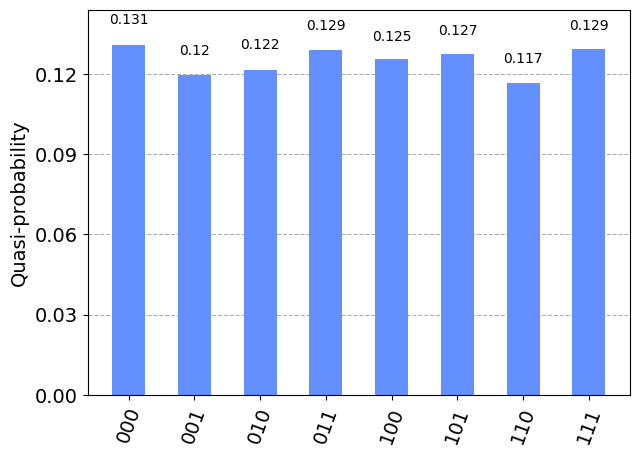

In [195]:

job = sampler.run(teleport_def) # , shots=2048)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())

#### 2. Verified that it works using the swap test

We can use the swap test to verify better if the teleport circuit works.

In Qiskit we can build circuits modularly, using functions as block, however this block must not contain measurements.
We define a function that build the teleport circuit and another one that build the swap test.


In [11]:

def teleport_circuit():
    teleport_circ = QuantumCircuit(3, name='teleport')
    teleport_circ.h(1)
    teleport_circ.cx(1, 2)
    teleport_circ.cx(0, 1)
    teleport_circ.h(0)
    teleport_circ.barrier()
    teleport_circ.cx(1,2)
    teleport_circ.cz(0,2)
    teleport_circ.draw()
    
    return teleport_circ


teleport = teleport_circuit()
teleport.draw()


┌───┐ ░         
q_0: ────────────■──┤ H ├─░───────■─
     ┌───┐     ┌─┴─┐└───┘ ░       │ 
q_1: ┤ H ├──■──┤ X ├──────░───■───┼─
     └───┘┌─┴─┐└───┘      ░ ┌─┴─┐ │ 
q_2: ─────┤ X ├───────────░─┤ X ├─■─
          └───┘           ░ └───┘

In [19]:
def swap_circuit():
    qc = QuantumCircuit(3, name='swap')
    qc.h(0)
    qc.cswap(0,1,2)
    qc.h(0)
    
    return qc

swap = swap_test()
swap.draw()

┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├
     └───┘ │ └───┘
q_1: ──────X──────
           │      
q_2: ──────X──────

Now we can put together and add the measurement.
First we initialize the circuit

In [22]:
from qiskit import ClassicalRegister, QuantumRegister


alice = QuantumRegister(1, 'alice')
a_test = QuantumRegister(1, 'alice_test')
tel_supp = QuantumRegister(1, 'teleport_supp')
bob = QuantumRegister(1, 'bob')
swap_supp = QuantumRegister(1, 'swap_supp')

garb = ClassicalRegister(2,'garb')
res = ClassicalRegister(1,'res')
qc = QuantumCircuit(alice, tel_supp, bob, a_test, swap_supp, garb, res)

phi = Statevector([1/sqrt(2), -1/sqrt(2)])
qc.initialize(phi,alice[0])
qc.initialize(phi,a_test[0])


qc.draw()

┌──────────────────────────────┐
        alice: ┤ Initialize(0.70711,-0.70711) ├
               └──────────────────────────────┘
teleport_supp: ────────────────────────────────
                                               
          bob: ────────────────────────────────
               ┌──────────────────────────────┐
   alice_test: ┤ Initialize(0.70711,-0.70711) ├
               └──────────────────────────────┘
    swap_supp: ────────────────────────────────
                                               
       garb: 2/════════════════════════════════
                                               
        res: 1/════════════════════════════════

Here we add the teleport block and the measurement to complete the protocol

In [23]:
qc.append(teleport_circuit(), [alice, tel_supp, bob])
qc.measure(alice, garb[0])
qc.measure(tel_supp, garb[1])
qc.draw()

┌──────────────────────────────┐┌───────────┐┌─┐   
        alice: ┤ Initialize(0.70711,-0.70711) ├┤0          ├┤M├───
               └──────────────────────────────┘│           │└╥┘┌─┐
teleport_supp: ────────────────────────────────┤1 teleport ├─╫─┤M├
                                               │           │ ║ └╥┘
          bob: ────────────────────────────────┤2          ├─╫──╫─
               ┌──────────────────────────────┐└───────────┘ ║  ║ 
   alice_test: ┤ Initialize(0.70711,-0.70711) ├──────────────╫──╫─
               └──────────────────────────────┘              ║  ║ 
    swap_supp: ──────────────────────────────────────────────╫──╫─
                                                             ║  ║ 
       garb: 2/══════════════════════════════════════════════╩══╩═
                                                             0  1 
        res: 1/═══════════════════════════════════════════════════

Now we can perform the swap test between the qubit `bob` and `alice_test`, that contains a copy of `alice`

In [24]:
qc.append(swap_circuit(), [swap_supp, a_test, bob])
qc.measure(swap_supp, res[0])
qc.draw()

┌──────────────────────────────┐┌───────────┐┌─┐               
        alice: ┤ Initialize(0.70711,-0.70711) ├┤0          ├┤M├───────────────
               └──────────────────────────────┘│           │└╥┘┌─┐            
teleport_supp: ────────────────────────────────┤1 teleport ├─╫─┤M├────────────
                                               │           │ ║ └╥┘┌───────┐   
          bob: ────────────────────────────────┤2          ├─╫──╫─┤2      ├───
               ┌──────────────────────────────┐└───────────┘ ║  ║ │       │   
   alice_test: ┤ Initialize(0.70711,-0.70711) ├──────────────╫──╫─┤1 swap ├───
               └──────────────────────────────┘              ║  ║ │       │┌─┐
    swap_supp: ──────────────────────────────────────────────╫──╫─┤0      ├┤M├
                                                             ║  ║ └───────┘└╥┘
       garb: 2/══════════════════════════════════════════════╩══╩═══════════╬═
                                                             0  1           ║ 
        res: 1/═════════════════════════════════════════════════════════════╩═
                                                                            0

Finally, we can simulate the circuit, we see that he first classical big (`res`) is always 0

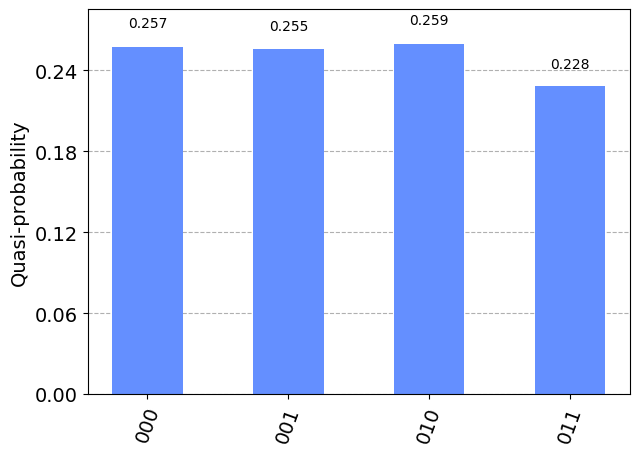

In [28]:
job = sampler.run(qc, shots=2048)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())

### 3. Implement this circuit

<img src="Image/thumbnail_Image.png" width=1000 />